# Basic analysis of the full dataset using PySpark

## What's in this section ?
- Here we load large datasets locally using Spark. We first load the full_ratings dataset to vizualise the distribution of the reviews and ratings.
- Then we load the full dataset by category, for the moment we did Electronics and Office products. We use these datasets to vizualise the distribution of the reviews. 

In [1]:
# Import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from pyspark import SparkContext
from pyspark import SparkConf
import pandas as pd
import numpy as np


# Import the libraries to draw
import matplotlib.pyplot as plt
import seaborn as sns

# Import helpers functions
from spark_helpers import *

#Create a spark session
spark = SparkSession.builder.appName("Spark Session").config("spark.sql.crossJoin.enabled","true").getOrCreate()
sc = SparkContext.getOrCreate()

## Full Ratings Analysis

Firs, we study the distribution of the full ratings. To do that we load the full ratings (3.37Go) and treat it with PySpark. We will output the distribution of the number of products relative to the number of reviews (i.e 10 products have 15 reviews ...).

In [2]:
# Load the full ratings data
df_full_ratings = spark.read.format('csv').option("header","false").load('all_ratings.csv')
df_full_ratings.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)



In [3]:
# Display the first 20 rows 
df_full_ratings.take(10)

[Row(_c0='A3AF8FFZAZYNE5', _c1='0000000078', _c2='5.0', _c3='1092182400'),
 Row(_c0='AH2L9G3DQHHAJ', _c1='0000000116', _c2='4.0', _c3='1019865600'),
 Row(_c0='A2IIIDRK3PRRZY', _c1='0000000116', _c2='1.0', _c3='1395619200'),
 Row(_c0='A1TADCM7YWPQ8M', _c1='0000000868', _c2='4.0', _c3='1031702400'),
 Row(_c0='AWGH7V0BDOJKB', _c1='0000013714', _c2='4.0', _c3='1383177600'),
 Row(_c0='A3UTQPQPM4TQO0', _c1='0000013714', _c2='5.0', _c3='1374883200'),
 Row(_c0='A8ZS0I5L5V31B', _c1='0000013714', _c2='5.0', _c3='1393632000'),
 Row(_c0='ACNGUPJ3A3TM9', _c1='0000013714', _c2='4.0', _c3='1386028800'),
 Row(_c0='A3BED5QFJWK88M', _c1='0000013714', _c2='4.0', _c3='1350345600'),
 Row(_c0='A2SUAM1J3GNN3B', _c1='0000013714', _c2='5.0', _c3='1252800000')]

We see in the schema that the ratings and UNIX time are stored as string, to do computation on them we cast the columns as float numbers.

In [4]:
# Cast the ratings and UNIX time as float number
df_full_ratings = df_full_ratings.select(df_full_ratings._c0, df_full_ratings._c1, df_full_ratings._c2.cast('float')\
                                         ,df_full_ratings._c3.cast('float'))

In [5]:
# Rename the columns and print the new schema
df_full_ratings = df_full_ratings.selectExpr("_c0 as reviewerID", "_c1 as asin", "_c2 as ratings", "_c3 as UNIX_time")
df_full_ratings.printSchema()

root
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- ratings: float (nullable = true)
 |-- UNIX_time: float (nullable = true)



### Number of reviews by product
First we compute the number of reviews by product to see its distribution.

In [6]:
# Do a Group By Product of all the ratings
groupRatingsByProduct = df_full_ratings.groupBy('asin')
# Compute the number of reviews by product
ratings_count_by_product = groupRatingsByProduct.count()

In [7]:
ratings_count_by_product.take(5)

[Row(asin='0001714422', count=2),
 Row(asin='0001837192', count=1),
 Row(asin='0001845357', count=1),
 Row(asin='0002151731', count=1),
 Row(asin='0002158140', count=1)]

In [8]:
ratings_count_by_product = ratings_count_by_product.selectExpr('asin', 'count as number_of_review')
ratings_count_by_product.printSchema()

root
 |-- asin: string (nullable = true)
 |-- number_of_review: long (nullable = false)



Here we have two options:

- Collect the full dataframe with the number of reviews for each items, the problem with this approach is that we have a high number of products (a little less than 10M). So the pandas dataframe would be too large.

- The second option is to group the spark dataframe by number of reviews, for example we group together all the products that have exactly 4 reviews. With this method we will significantly reduce the size of the dataframe and can use it with pandas. 

We went with the second option :

In [9]:
# We group by the number of reviews
groupByNumberOfReviews = ratings_count_by_product.groupBy('number_of_review')

In [10]:
# We count the number of articles for each number of reviews
tmp_df = groupByNumberOfReviews.count()
# Some renaming for easier use
tmp_df = tmp_df.selectExpr('number_of_review', 'count as number_of_product')

In [11]:
# Compute the number of reviews by product as a pandas dataframe for easier use
df_ratings_count_pd = tmp_df.toPandas()
# Save the number of ratings by product to a csv files
df_ratings_count_pd.to_csv('Full_ratings_count.csv')

In [12]:
df_ratings_count_pd.describe()

,number_of_review,number_of_product
count,2802.000000,2.802000e+03
mean,2072.989650,3.523987e+03
std,2436.728958,9.448883e+04
min,1.000000,1.000000e+00
25%,701.250000,1.000000e+00
50%,1418.500000,3.000000e+00
75%,2482.250000,1.600000e+01
max,25368.000000,4.615058e+06


In [28]:
number_of_product = df_ratings_count_pd.sum()
number_of_product = number_of_product['number_of_product']
print('There is ' + str(number_of_product) + ' products in the dataset')

There is 9874211 in the dataset


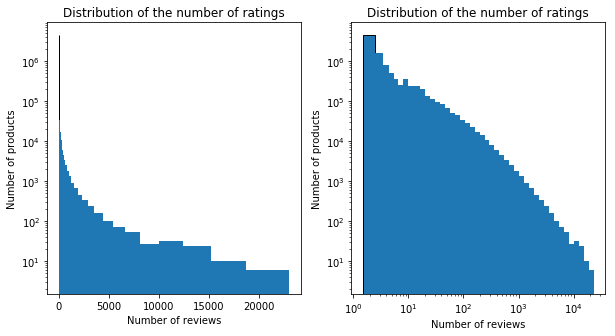

In [14]:
#Function used to draw the distribution of number of reviews per number of products
draw_full_ratings('Full_ratings_count.csv')

We nearly have a power law.

### Ratings distribution

We now observe the distribution of the ratings.

In [15]:
# Do a Group By Product of all the ratings
groupRatingsByRating = df_full_ratings.groupBy('ratings')
# Compute the number of reviews by product
ratings_count_by_rating = groupRatingsByRating.count()

In [16]:
ratings_count_by_rating = ratings_count_by_rating.selectExpr('ratings', 'count as number_of_review')
ratings_count_by_rating.printSchema()

root
 |-- ratings: float (nullable = true)
 |-- number_of_review: long (nullable = false)



In [17]:
# Compute the number of ratings by rating as a pandas dataframe for easier use
df_ratings_distribution_pd = ratings_count_by_rating.toPandas()
# Save the number of ratings by product to a csv files
df_ratings_distribution_pd.to_csv('Full_ratings_distribution.csv')

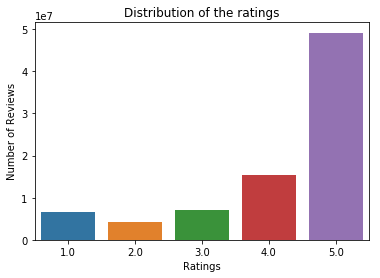

In [18]:
ax = sns.barplot(x = df_ratings_distribution_pd['ratings'], y = df_ratings_distribution_pd['number_of_review'])
ax.set_xlabel('Ratings')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of the ratings')
plt.show()

The ratings have a clear tendency to be >=4 

## Analysis of the distribution for each categories

Here are implemented functions used to load a category and output the distributions of the reviews

### Electronics Data

In [19]:
# Function used to load a category dataset using spark
df_electronics = load_file_cat("reviews_Electronics.json.gz",'json',spark)
# Get the number of distinct reviewers in the category
distinct_reviews_electronics = df_electronics.count()
print("There is " + str(distinct_reviews_electronics) + " distinct reviews")

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)

There is 7824482 distinct reviews


In [20]:
# Function used to compute the number of review per product using a spark
# dataframe and save it as a pandas dataframe
df_review_count_electronics_pd = compute_review_per_product(df_electronics,'Electronics_Review_Count.csv')

Let's vizualise the distribution :

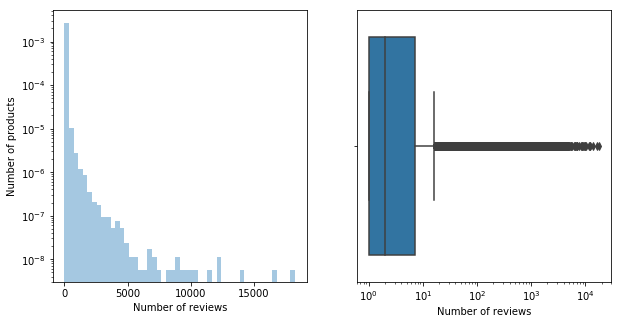

In [21]:
#Function used to draw the distribution of number of reviews per
#number of products
draw_distribution(csv = 'Electronics_Review_Count.csv')

In [22]:
# Compute the statistics of the number of reviews by product
df_review_count_electronics_pd.describe()

,count
count,476002.000000
mean,16.437918
std,112.702633
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,18244.000000


We see that the majority of products have less than 2 reviews, as we want to do a study on multiple reviews for each reviewer and products, we will use the 5-cores dataset for electronics.

### Office Products Data

In [24]:
df_office = load_file_cat("reviews_Office_Products.json.gz",'json',spark)
# Get the number of distinct reviewers in the category
distinct_reviews_office = df_office.count()
print("There is " + str(distinct_reviews_office) + " distinct reviews")

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)

There is 1243186 distinct reviews


In [25]:
df_review_count_office_pd = compute_review_per_product(df_office,'Office_Review_Count.csv')

Let's vizualise the distribution :

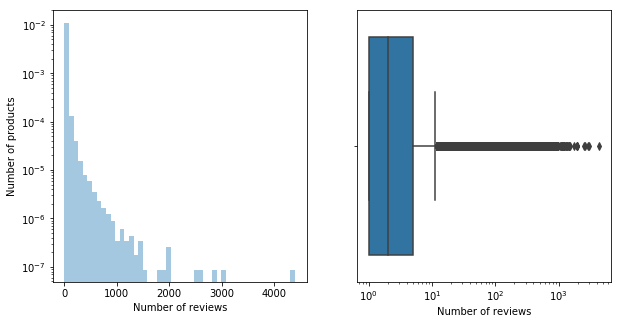

In [26]:
draw_distribution(csv = 'Office_Review_Count.csv')

In [27]:
# Compute the quantiles of the number of reviews by product
df_review_count_office_pd.describe()

,count
count,130006.000000
mean,9.562528
std,44.592114
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,4398.000000


## What's next in this section ?

- We will expand our analysis to the other categories.
- We will also analyze the UNIX time of the reviews (already load in the full_ratings).